In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from filterpy.kalman import IMMEstimator
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

## Formulation derivation

Start from the newtonian equation


\begin{align}
x = \frac{1}{2}at^2 + v_0t + x_0
\end{align}

where

\begin{align}
v = \dot{x} \text{ and } a = \ddot{x}
\end{align}

Add control input $\textit{u}$ that has a transfer matrix $\textit{B}$ to convert to effect

From a second order differential eqaution and reduce it the a first order

\begin{align}
\ddot{x} = a_1/a_3 x_2 + a_2/a_3 x_1 + 1/a_3 u
\end{align}

lets label $x_1 = x$ and $x_2 = \dot{x}$ leads $\dot{x_2} = \ddot{x}$

therefore, first order

\begin{align}
\dot{x_1} &= x_2 \\
\dot{x_2} &= a_1/a_3 x_2 + a_2/a_3 x_1 + 1/a_3 u
\end{align}

Then we can write this in the matrix format

\begin{align}

\begin{bmatrix}
\dot{x_1} \\ \dot{x_2} 
\end{bmatrix}

=

\begin{bmatrix}
0 & 1 \\
a_1/a_3 & a_2/a_3
\end{bmatrix}

\begin{bmatrix}
x_1 \\ x_2
\end{bmatrix}

+ 

\begin{bmatrix}
0 \\ 1/a_3 
\end{bmatrix}

u

\end{align}

which in the form of $\dot{x} = A x + Bu$

Then we can add white noise into our system

\begin{align}
Q = \int_0^{\Delta t} F(t) Q_c F^T(t) dt
\end{align}

when 

\begin{align}
F &= \begin{bmatrix} 1 & \Delta t & \Delta t^2 /2 \\ 0 & 1 & \Delta t \\ 0 & 0 & 1 \end{bmatrix} \\
Q_c &= \begin{bmatrix} 0 & 0 & 0 \\ 0 & 0 & 0 \\ 0 & 0 & 1 \end{bmatrix}
\end{align}


In [1]:
import sympy
from sympy import (init_printing, Matrix, MatMul, 
                   integrate, symbols)

init_printing(use_latex='mathjax')
dt, phi = symbols('\Delta{t} \Phi_s')
F_k = Matrix([[1, dt, dt**2/2],
              [0,  1,      dt],
              [0,  0,       1]])
Q_c = Matrix([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1]])*phi

Q = integrate(F_k * Q_c * F_k.T, (dt, 0, dt))

# factor phi out of the matrix to make it more readable
Q = Q / phi
MatMul(Q, phi)

⎡         5           4           3⎤      
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────  ──────────⎥      
⎢    20          8           6     ⎥      
⎢                                  ⎥      
⎢         4           3           2⎥      
⎢\Delta{t}   \Delta{t}   \Delta{t} ⎥      
⎢──────────  ──────────  ──────────⎥⋅\Phiₛ
⎢    8           3           2     ⎥      
⎢                                  ⎥      
⎢         3           2            ⎥      
⎢\Delta{t}   \Delta{t}             ⎥      
⎢──────────  ──────────  \Delta{t} ⎥      
⎣    6           2                 ⎦      

## IMM tracker

Lets form prior probability for events
$\mu = [p_{straight}, p_{turn}] \rightarrow P(A|B) \\ 
P(A) = \sum P(A|B)P(B) \\
c_j = \sum_{i=1}^{N}\mu_jM_{ij}$

In [26]:

mu = np.array([0.7,0.3]) # Probability of maneuver
M = np.array([[.97, .03], [.05, .95]]) # Transition matrix

cbar = np.dot(mu, M)

bayes
$ post = \frac{prior \dot likelihood}{norm}
$

$ Likelihood = \frac{1}{\sqrt{2 \pi S}} e^{-\frac{1}{2}y^TS^{-1}y}
$

Therefore update

$\mu_i = ||L_i \cdot c_i||$

Then mix probabilities to avoid overflows
weight
$ x_j^m = \sum_{i=1}^{N} w_{ij}x_i
$

covariance
$ P_j^m = \sum_{i=1}^{N}w_{ij} [(x^i-x_i^m)(x^i-x_i^m)^T + P_i]
$

Giving
$w_{ij} = ||\mu_i \cdot M_{ij}||
$

Final format for the prediction step is

$ x_j = F_jx_j^m \\
P_j = F_jP^m_jF_j^T + Q_j
$

In [27]:
L = [0.000134, 0.0000748] 
mu = cbar * L
mu /= sum(mu) # normalize

omega = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        omega[i, j] = (M[i, j] * mu[i]) / cbar[j]

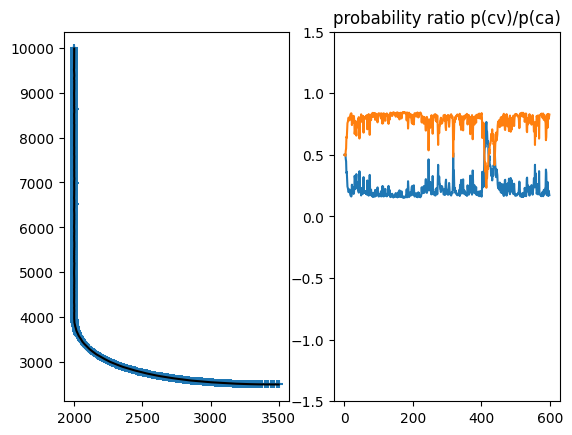

In [38]:
#Simulate Data
#Track 600 timesteps every 1s

N = 600 
dt = 1
imm_track = turning_target(N) # Simulate a moving target, output x and y positions

# add noise
zs = np.zeros((N, 2))
r = 1
for i in range(N):
    zs[i, 0] = imm_track[i, 0] + np.random.randn()*r
    zs[i, 1] = imm_track[i, 2] + np.random.randn()*r
    
#Matrices for filter
dt2 = (dt**2)/2

F = np.array([[1, dt, dt2],
              [0,  1,  dt],
              [0,  0,   1]])
x = np.array([[2000., 0, 0, 10000, -15, 0]]).T

Q = np.array([[.05, .125, 1/6],
              [.125, 1/3, .5],
              [1/6, .5, 1]])*1.e-3
H = np.array([[1, 0, 0, 0, 0, 0],
                 [0, 0, 0, 1, 0, 0]])

P = 1.e-12
R = r**2

filterClass_1 = OwnKalman(6,2)
filterClass_2 = OwnKalman(6,2)
B = None
filterClass_1.add_matrix(P,x,R,Q,H,F,B)
filterClass_2.add_matrix(P,x,R,Q*0,H,F,B)

filters = [filterClass_1.returnFilter(), filterClass_2.returnFilter()]

M = np.array([[0.97, 0.03],
              [0.03, 0.97]])

mu = np.array([0.5, 0.5])
bank = IMMEstimator(filters, mu, M)

xs, probs = [], []
for i, z in enumerate(zs):
    z = np.array([z]).T
    bank.predict()
    bank.update(z)

    xs.append(bank.x.copy())
    probs.append(bank.mu.copy())

xs = np.array(xs)
probs = np.array(probs)
plt.subplot(121)
plt.plot(xs[:, 0], xs[:, 3], 'k')
plt.scatter(zs[:, 0], zs[:, 1], marker='+')

plt.subplot(122)
plt.plot(probs[:, 0])
plt.plot(probs[:, 1])
plt.ylim(-1.5, 1.5)
plt.title('probability ratio p(cv)/p(ca)');

In [36]:
class OwnKalman:
    def __init__(self,x,z):
        self.kalman = KalmanFilter(x, z)
    
    def add_matrix(self,P,x,R,Q,H,F,B):
        self.kalman.P *= P #covariance matrix
        self.kalman.x = x #filter state estimate
        self.kalman.R *= R #measurement uncertainty/noise
        self.kalman.Q = block_diag(Q, Q) #Process uncertainty/noise
        self.kalman.H = H #measurement function
        self.kalman.F = block_diag(F, F) #state transistion matrix
        self.kalman.B = None #control transition matrix
        
    def returnFilter(self):
        return self.kalman

In [87]:
# simulate data and add noise
zs = np.zeros((N, 2))
r = 1
for i in range(N):
    zs[i, 0] = imm_track[i, 0] + np.random.randn()*r
    zs[i, 1] = imm_track[i, 2] + np.random.randn()*r

In [91]:
from filterpy.kalman import MerweScaledSigmaPoints
from filterpy.kalman import UnscentedKalmanFilter as UKF

class UKF_filter():
    
    def __init__(self):
        self.simgas = None
        self.ukf = None
        self.filtered_x = []

    def f_cv2Dmodel(self, x, dt):        
        F = np.array([[1, dt, 0,  0],
                      [0,  1, 0,  0],
                      [0,  0, 1, dt],
                      [0,  0, 0,  1]])
        return F @ x

    def h_cv2Dmodel(self,x):
        return x[[0, 2]]

    def f_cv3Dmodel(self, x, dt):        
        F = np.array([[1, 1*dt, dt**2, 0, 0, 0],
                      [0,  1*dt, dt**2, 0, 0, 0],
                      [0,  0, 1, 0, 0, 0],
                      [0, 0, 0, 1, 1*dt, dt**2],
                      [0, 0, 0, 0, 1*dt, dt**2],
                      [0,  0, 0, 0, 0, 1]])
        return F @ x

    def h_cv3Dmodel(self,x):
        return x[[0, 3]]
        
    def createFilter(self, x, R, P, Q_1,Q_2):
        self.sigmas = MerweScaledSigmaPoints(n=4, alpha=.1, beta=2., kappa=1.)
        self.ukf = UKF(dim_x=4, dim_z=2, fx=self.f_cv2Dmodel,
          hx=self.h_cv2Dmodel, dt=dt, points=self.sigmas)
        
        self.ukf.x = x
        self.ukf.R = R
        self.ukf.Q[0:2, 0:2] = Q_1
        self.ukf.Q[2:4, 2:4] = Q_2
        self.ukf.P = P
        
    def ukf_Predict_Update(self,z):
        self.ukf.predict()
        self.ukf.update(z)
        self.filtered_x.append(self.ukf.x.copy())
        
    def OutResults(self):
        return np.array(self.filtered_x) 
    
    def filterbatch(self,zs):
        return self.ukf.batch_filter(zs)
        

In [92]:

x = np.array([0., 0., 0., 0.])
R = np.diag([0.09, 0.09]) 
P = np.diag([1**2, 1**2, 1**2, 1**2])
Q_1 = Q_discrete_white_noise(2, dt=1, var=0.02)
Q_2 = Q_discrete_white_noise(2, dt=1, var=0.02) 

ukfTest = UKF_filter()
ukfTest.createFilter(x, R, P, Q_1, Q_2)

UKF standard deviation 86.864 meters


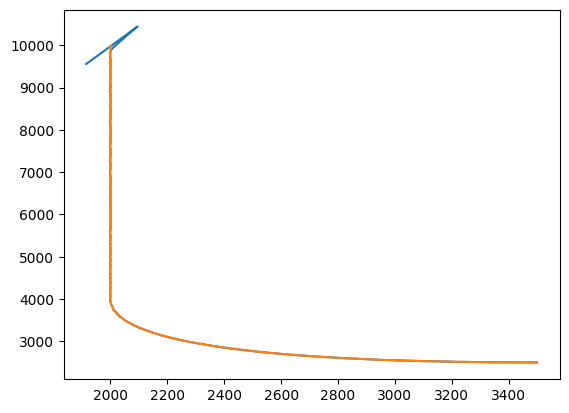

In [93]:
for z in zs:
    ukfTest.ukf_Predict_Update(z)

uxs = ukfTest.OutResults()

plt.plot(uxs[:, 0], uxs[:, 2])
plt.plot(zs[:, 0], zs[:, 1])
print(f'UKF standard deviation {np.std(uxs - xs):.3f} meters')

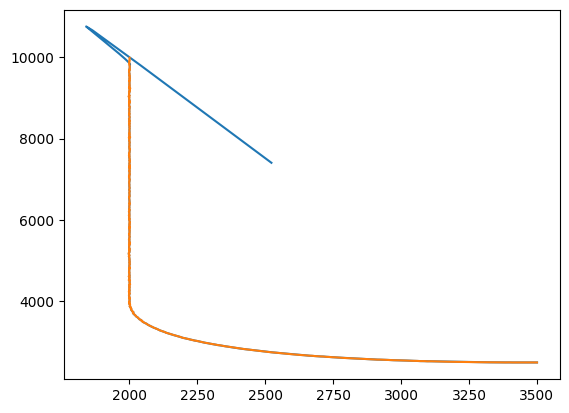

In [72]:
xs,_ = ukfTest.filterbatch(zs)
plt.plot(xs[:, 0], xs[:, 2]);
plt.plot(zs[:, 0], zs[:, 1]);

In [25]:
# -*- coding: utf-8 -*-

"""Copyright 2015 Roger R Labbe Jr.
Code supporting the book
Kalman and Bayesian Filters in Python
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python
This is licensed under an MIT license. See the LICENSE.txt file
for more information.
"""

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from matplotlib.patches import Circle, Rectangle, Polygon, Arrow, FancyArrow
import matplotlib.pyplot as plt
import numpy as np


def plot_track_and_residuals(dt, xs, z_xs, res):
    """ plots track and measurement on the left, and the residual
    of the filter on the right. Helps to visualize the performance of
    an adaptive filter.
    """
    
    assert np.isscalar(dt)
    t = np.arange(0, len(xs)*dt, dt)
    plt.subplot(121)
    if z_xs is not None:
        plot_measurements(t, z_xs, label='z')
    plot_filter(t, xs)
    plt.legend(loc=2)
    plt.xlabel('time (sec)')
    plt.ylabel('X')
    plt.title('estimates vs measurements')
    plt.subplot(122)
    # plot twice so it has the same color as the plot to the left!
    plt.plot(t, res)
    plt.plot(t, res)
    plt.xlabel('time (sec)')
    plt.ylabel('residual')
    plt.title('residuals')
    plt.show()


def plot_markov_chain():
    """ show a markov chain showing relative probability of an object
    turning"""
    
    fig = plt.figure(figsize=(4,4), facecolor='w')
    ax = plt.axes((0, 0, 1, 1),
                  xticks=[], yticks=[], frameon=False)

    box_bg = '#DDDDDD'

    kf1c = Circle((4,5), 0.5, fc=box_bg)
    kf2c = Circle((6,5), 0.5, fc=box_bg)
    ax.add_patch (kf1c)
    ax.add_patch (kf2c)

    plt.text(4,5, "Straight",ha='center', va='center', fontsize=14)
    plt.text(6,5, "Turn",ha='center', va='center', fontsize=14)


    #btm
    plt.text(5, 3.9, ".05", ha='center', va='center', fontsize=18)
    ax.annotate('',
                xy=(4.1, 4.5),  xycoords='data',
                xytext=(6, 4.5), textcoords='data',
                size=10,
                arrowprops=dict(arrowstyle="->",
                                ec="k",
                                connectionstyle="arc3,rad=-0.5"))
    #top
    plt.text(5, 6.1, ".03", ha='center', va='center', fontsize=18)
    ax.annotate('',
                xy=(6, 5.5),  xycoords='data',
                xytext=(4.1, 5.5), textcoords='data',
                size=10,

                arrowprops=dict(arrowstyle="->",
                                ec="k",
                                connectionstyle="arc3,rad=-0.5"))

    plt.text(3.5, 5.6, ".97", ha='center', va='center', fontsize=18)
    ax.annotate('',
                xy=(3.9, 5.5),  xycoords='data',
                xytext=(3.55, 5.2), textcoords='data',
                size=10,
                arrowprops=dict(arrowstyle="->",
                                ec="k",
                                connectionstyle="angle3,angleA=150,angleB=0"))

    plt.text(6.5, 5.6, ".95", ha='center', va='center', fontsize=18)
    ax.annotate('',
                xy=(6.1, 5.5),  xycoords='data',
                xytext=(6.45, 5.2), textcoords='data',
                size=10,
                arrowprops=dict(arrowstyle="->",
                                fc="0.2", ec="k",
                                connectionstyle="angle3,angleA=-150,angleB=2"))


    plt.axis('equal')
    plt.show()


def turning_target(N=600, turn_start=400):
    """ simulate a moving target"""

    #r = 1.
    dt = 1.
    phi_sim = np.array(
        [[1, dt, 0, 0],
         [0, 1, 0, 0],
         [0, 0, 1, dt],
         [0, 0, 0, 1]])

    gam = np.array([[dt**2/2, 0],
                    [dt, 0],
                    [0, dt**2/2],
                    [0, dt]])

    x = np.array([[2000, 0, 10000, -15.]]).T

    simxs = []

    for i in range(N):
        x = np.dot(phi_sim, x)
        if i >= turn_start:
            x += np.dot(gam, np.array([[.075, .075]]).T)
        simxs.append(x)
    simxs = np.array(simxs)

    return simxs


if __name__ ==  "__main__":
    d = turning_target()

In [24]:
# -*- coding: utf-8 -*-

"""Copyright 2015 Roger R Labbe Jr.


Code supporting the book

Kalman and Bayesian Filters in Python
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python


This is licensed under an MIT license. See the LICENSE.txt file
for more information.
"""

from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from contextlib import contextmanager
import ipywidgets
import matplotlib as mpl
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np


_default_size = (9, 4)

def equal_axis(sz=_default_size[0]):
    """ set size of axis in inches, using the same for each"""
    pylab.rcParams['figure.figsize'] = sz, sz
    plt.axis('equal')

def reset_figsize():
    """ reest axis size in inches to the default size for the book"""
    mpl.rcParams['figure.figsize'] = _default_size


def set_figsize(x=_default_size[0], y=_default_size[1]):
    """ set the figure size of the plot to the specified size in inches"""

    mpl.rcParams['figure.figsize'] = x, y


@contextmanager
def figsize(x=8, y=3):
    """Temporarily set the figure size using 'with figsize(a, b):'"""

    size = pylab.rcParams['figure.figsize']
    set_figsize(x, y)
    yield
    pylab.rcParams['figure.figsize'] = size


""" If the plot is inline (%matplotlib inline) we need to
do special processing for the interactive_plot context manager,
otherwise it outputs a lot of extra <matplotlib.figure.figure
type output into the notebook."""

IS_INLINE = mpl.get_backend().find('backend_inline') != -1


def plot_errorbars(bars, xlims, ylims=(-1, 1)):
    """Plots a list of error bars with optional x and y limits.
    The list `bars` is a list of tuples (or any iterable) containing

    (mean value, error plus/minus, label)

    For example (160, 3, 'A') draws an error bar from 157 to 163, with the
    legend label 'A`)

    Parameters
    ----------

    bars : list
        list of tuples in form (mean, error +/-, label)

    x-lims : tuple
        tuple containing min and max values for x axis

    y-lims : tuple, optional
        tuple containing min and max values for y axis ( the default is (-1, 1))

    Example
    -------
    >>> plot_errorbars([(160, 3, 'A'), (170, 9, 'B')], xlims=(150, 180))
    """

    with figsize(y=2):
        i = 0.0
        for bar in bars:
            plt.errorbar([bar[0]], [i], xerr=[bar[1]], fmt='o', label=bar[2] , capthick=2, capsize=10)
            i += 0.2

        plt.ylim(*ylims)
        plt.xlim(xlims[0], xlims[1])
        show_legend()
        plt.gca().axes.yaxis.set_ticks([])
        plt.show()


def predict_update_chart(box_bg = '#CCCCCC',
                arrow1 = '#88CCFF',
                arrow2 = '#88FF88'):
    plt.figure(figsize=(4, 4), facecolor='w')
    ax = plt.axes((0, 0, 1, 1),
                  xticks=[], yticks=[], frameon=False)

    pc = Circle((4, 5), 0.7, fc=box_bg)
    uc = Circle((6, 5), 0.7, fc=box_bg)
    ax.add_patch (pc)
    ax.add_patch (uc)

    plt.text(4, 5, "Predict\nStep",ha='center', va='center', fontsize=12)
    plt.text(6, 5, "Update\nStep",ha='center', va='center', fontsize=12)

    #btm arrow from update to predict
    ax.annotate('',
                xy=(4.1, 4.5),  xycoords='data',
                xytext=(6, 4.5), textcoords='data',
                size=20,
                arrowprops=dict(arrowstyle="simple",
                                fc="0.6", ec="none",
                                patchB=pc,
                                patchA=uc,
                                connectionstyle="arc3,rad=-0.5"))
    #top arrow from predict to update
    ax.annotate('',
                xy=(6, 5.5),  xycoords='data',
                xytext=(4.1, 5.5), textcoords='data',
                size=20,
                arrowprops=dict(arrowstyle="simple",
                                fc="0.6", ec="none",
                                patchB=uc,
                                patchA=pc,
                                connectionstyle="arc3,rad=-0.5"))

    ax.annotate('Measurement ($\mathbf{z_k}$)',
                xy=(6.3, 5.6),  xycoords='data',
                xytext=(6,6), textcoords='data',
                size=14,
                arrowprops=dict(arrowstyle="simple",
                                fc="0.6", ec="none"))

    # arrow from predict to state estimate
    ax.annotate('',
                xy=(4.0, 3.8),  xycoords='data',
                xytext=(4.0,4.3), textcoords='data',
                size=12,
                arrowprops=dict(arrowstyle="simple",
                                fc="0.6", ec="none"))

    ax.annotate('Initial\nConditions ($\mathbf{x_0}$)',
                xy=(4.05, 5.7),  xycoords='data',
                xytext=(2.5, 6.5), textcoords='data',
                size=14,
                arrowprops=dict(arrowstyle="simple",
                                fc="0.6", ec="none"))

    plt.text (4, 3.7,'State Estimate ($\mathbf{\hat{x}_k}$)',
              ha='center', va='center', fontsize=14)
    plt.axis('equal')
    plt.show()


def show_residual_chart(show_eq=True, show_H=False):
    plt.figure(figsize=(11, 3.), facecolor='w')
    est_y = ((164.2 - 158)*.8 + 158)

    ax = plt.axes(xticks=[], yticks=[], frameon=False)
    ax.annotate('', xy=[1,159], xytext=[0, 158],
                arrowprops=dict(arrowstyle='->',
                                ec='r', lw=3, shrinkA=6, shrinkB=5))

    ax.annotate('', xy=[1, 159], xytext=[1, 164.2],
                arrowprops=dict(arrowstyle='-',
                                ec='k', lw=3, shrinkA=8, shrinkB=8))

    ax.annotate('', xy=(1., est_y), xytext=(0.9, est_y),
                arrowprops=dict(arrowstyle='->', ec='#004080',
                                lw=2,
                                shrinkA=3, shrinkB=4))


    plt.scatter ([0,1], [158.0,est_y], c='k',s=128)
    plt.scatter ([1], [164.2], c='b',s=128)
    plt.scatter ([1], [159], c='r', s=128)
    plt.text (1.05, 158.8, r"prior $(\bar{x}_t)$", ha='center',va='top',fontsize=18,color='red')
    plt.text (0.5, 159.6, "prediction", ha='center',va='top',fontsize=18,color='red')
    plt.text (1.0, 164.4, r"measurement ($z$)",ha='center',va='bottom',fontsize=18,color='blue')
    plt.text (0, 157.8, r"posterior ($x_{t-1}$)", ha='center', va='top',fontsize=18)
    plt.text (1.02, est_y-1.5, "residual($y$)", ha='left', va='center',fontsize=18)
    if show_eq:
        if show_H:
            plt.text (1.02, est_y-2.2, r"$y=z-H\bar x_t$", ha='left', va='center',fontsize=18)
        else:
            plt.text (1.02, est_y-2.2, r"$y=z-\bar x_t$", ha='left', va='center',fontsize=18)
    plt.text (0.9, est_y, "new estimate ($x_t$)", ha='right', va='center',fontsize=18)
    plt.text (0.8, est_y-0.5, "(posterior)", ha='right', va='center',fontsize=18)
    if show_eq:
        plt.text (0.75, est_y-1.2, r"$\bar{x}_t + Ky$", ha='right', va='center',fontsize=18)
    plt.xlabel('time')
    ax.yaxis.set_label_position("right")
    plt.ylabel('state')
    plt.xlim(-0.1, 1.5)


def show_legend():
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


def bar_plot(pos, x=None, ylim=(0,1), title=None, c='#30a2da',
             **kwargs):
    """ plot the values in `pos` as a bar plot.

    **Parameters**

    pos : list-like
        list of values to plot as bars

    x : list-like, optional
         If provided, specifies the x value for each value in pos. If not
         provided, the first pos element is plotted at x == 0, the second
         at 1, etc.

    ylim : (lower, upper), default = (0,1)
        specifies the lower and upper limits for the y-axis

    title : str, optional
        If specified, provides a title for the plot

    c : color, default='#30a2da'
        Color for the bars

    **kwargs : keywords, optional
        extra keyword arguments passed to ax.bar()

    """

    ax = plt.gca()
    if x is None:
        x = np.arange(len(pos))
    ax.bar(x, pos, color=c, **kwargs)
    if ylim:
        plt.ylim(ylim)
    plt.xticks(np.asarray(x), x)
    if title is not None:
        plt.title(title)


def plot_belief_vs_prior(belief, prior, **kwargs):
    """ plots two discrete probability distributions side by side, with
    titles "belief" and "prior"
    """

    plt.subplot(121)
    bar_plot(belief, title='belief', **kwargs)
    plt.subplot(122)
    bar_plot(prior, title='prior', **kwargs)


def plot_prior_vs_posterior(prior, posterior, reverse=False, **kwargs):
    """ plots two discrete probability distributions side by side, with
    titles "prior" and "posterior"
    """
    if reverse:
        plt.subplot(121)
        bar_plot(posterior, title='posterior', **kwargs)
        plt.subplot(122)
        bar_plot(prior, title='prior', **kwargs)
    else:
        plt.subplot(121)
        bar_plot(prior, title='prior', **kwargs)
        plt.subplot(122)
        bar_plot(posterior, title='posterior', **kwargs)


def set_labels(title=None, x=None, y=None):
    """ helps make code in book shorter. Optional set title, xlabel and ylabel
    """
    if x is not None:
        plt.xlabel(x)
    if y is not None:
        plt.ylabel(y)
    if title is not None:
        plt.title(title)


def set_limits(x, y):
    """ helper function to make code in book shorter. Set the limits for the x
    and y axis.
    """

    plt.gca().set_xlim(x)
    plt.gca().set_ylim(y)

def plot_predictions(p, rng=None, label='Prediction'):
    if rng is None:
        rng = range(len(p))
    plt.scatter(rng, p, marker='v', s=40, edgecolor='r',
                facecolor='None', lw=2, label=label)


def plot_kf_output(xs, filter_xs, zs, title=None, aspect_equal=True):
    plot_filter(filter_xs[:, 0])
    plot_track(xs[:, 0])

    if zs is not None:
        plot_measurements(zs)
    show_legend()
    set_labels(title=title, y='meters', x='time (sec)')
    if aspect_equal:
        plt.gca().set_aspect('equal')
    plt.xlim((-1, len(xs)))
    plt.show()


def FloatSlider(value, **kwargs):
    """
    Creates an ipwidgets FloatSlider with continuous update
    turned off
    """
    return ipywidgets.FloatSlider(value, continuous_update=False, **kwargs)


def IntSlider(value, **kwargs):
    """
    Creates an ipwidgets IntSlider with continuous update
    turned off
    """
    return ipywidgets.IntSlider(value, continuous_update=False, **kwargs)


def plot_measurements(xs, ys=None, dt=None, color='k', lw=1, label='Measurements',
                      lines=False, **kwargs):
    """ Helper function to give a consistent way to display
    measurements in the book.
    """
    if ys is None and dt is not None:
        ys = xs
        xs = np.arange(0, len(ys)*dt, dt)

    plt.autoscale(tight=False)
    if lines:
        if ys is not None:
            return plt.plot(xs, ys, color=color, lw=lw, ls='--', label=label, **kwargs)
        else:
            return plt.plot(xs, color=color, lw=lw, ls='--', label=label, **kwargs)
    else:
        if ys is not None:
            return plt.scatter(xs, ys, edgecolor=color, facecolor='none',
                        lw=2, label=label, **kwargs),
        else:
            return plt.scatter(range(len(xs)), xs, edgecolor=color, facecolor='none',
                        lw=2, label=label, **kwargs),


def plot_residual_limits(Ps, stds=1.):
    """ plots standard deviation given in Ps as a yellow shaded region. One std
    by default, use stds for a different choice (e.g. stds=3 for 3 standard
    deviations.
    """

    std = np.sqrt(Ps) * stds

    plt.plot(-std, color='k', ls=':', lw=2)
    plt.plot(std, color='k', ls=':', lw=2)
    plt.fill_between(range(len(std)), -std, std,
                 facecolor='#ffff00', alpha=0.3)


def plot_track(xs, ys=None, dt=None, label='Track', c='k', lw=2, **kwargs):
    if ys is None and dt is not None:
        ys = xs
        xs = np.arange(0, len(ys)*dt, dt)
    if ys is not None:
        return plt.plot(xs, ys, color=c, lw=lw, ls=':', label=label, **kwargs)
    else:
        return plt.plot(xs, color=c, lw=lw, ls=':', label=label, **kwargs)


def plot_filter(xs, ys=None, dt=None, c='C0', label='Filter', var=None, **kwargs):
    """ plot result of KF with color `c`, optionally displaying the variance
    of `xs`. Returns the list of lines generated by plt.plot()"""

    if ys is None and dt is not None:
        ys = xs
        xs = np.arange(0, len(ys) * dt, dt)
    if ys is None:
        ys = xs
        xs = range(len(ys))

    lines = plt.plot(xs, ys, color=c, label=label, **kwargs)
    if var is None:
        return lines

    var = np.asarray(var)
    std = np.sqrt(var)
    std_top = ys+std
    std_btm = ys-std

    plt.plot(xs, ys+std, linestyle=':', color='k', lw=2)
    plt.plot(xs, ys-std, linestyle=':', color='k', lw=2)
    plt.fill_between(xs, std_btm, std_top,
                     facecolor='yellow', alpha=0.2)

    return lines


def _blob(x, y, area, colour):
    """
    Draws a square-shaped blob with the given area (< 1) at
    the given coordinates.
    """
    hs = np.sqrt(area) / 2
    xcorners = np.array([x - hs, x + hs, x + hs, x - hs])
    ycorners = np.array([y - hs, y - hs, y + hs, y + hs])
    plt.fill(xcorners, ycorners, colour, edgecolor=colour)


def hinton(W, maxweight=None):
    """
    Draws a Hinton diagram for visualizing a weight matrix.
    Temporarily disables matplotlib interactive mode if it is on,
    otherwise this takes forever.
    """
    reenable = False
    if plt.isinteractive():
        plt.ioff()

    plt.clf()
    height, width = W.shape
    if not maxweight:
        maxweight = 2**np.ceil(np.log(np.max(np.abs(W)))/np.log(2))

    plt.fill(np.array([0, width, width, 0]),
             np.array([0, 0, height, height]),
             'gray')

    plt.axis('off')
    plt.axis('equal')
    for x in range(width):
        for y in range(height):
            _x = x+1
            _y = y+1
            w = W[y, x]
            if w > 0:
                _blob(_x - 0.5,
                      height - _y + 0.5,
                      min(1, w/maxweight),
                      'white')
            elif w < 0:
                _blob(_x - 0.5,
                      height - _y + 0.5,
                      min(1, -w/maxweight),
                      'black')
    if reenable:
        plt.ion()
